In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

Using TensorFlow backend.


In [78]:
label_encoder = preprocessing.LabelEncoder()

train_path = 'C:\Codes\datasets\surface_finder_dataset\career-con-2019'
x_train = pd.read_csv(train_path+'\X_train.csv')
y_train = pd.read_csv(train_path+'\y_train.csv')
x_test = pd.read_csv(train_path+'\X_test.csv')
x_train.groupby('series_id')
x_train = pd.merge(x_train,y_train,on='series_id')
#x_train.drop(['row_id','group_id','measurement_number'],axis=1,inplace=True)
x_train['surface'] = label_encoder.fit_transform(x_train['surface'])
print(sorted(x_train['surface'].unique()))
x_train.head()

[0, 1, 2, 3, 4, 5, 6, 7, 8]


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,2
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,2
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,2
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,2
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,2


In [79]:
num_series = x_train['series_id'].nunique()
num_series

3810

In [86]:
x = []
y = []
z = []

for i in range(3810):
    instance = np.array(x_train.loc[x_train['series_id']==i])
    split_instance = np.split(instance,[3,13],axis=1)
    x.append(split_instance[1])
    val = split_instance[2][0][1]
    #print(val)
    z.append(val)
    array_form = np.zeros((9))
    array_form[int(val)] = 1.
    y.append(array_form)
    
x = np.array(x)
y = np.array(y)
z = np.array(z,dtype=np.int32)
group_array = np.array(x_train['group_id'])
group_array = np.reshape(group_array,newshape=(num_series,128))[:,0]
x.shape,y.shape,z.shape,group_array.shape

((3810, 128, 10), (3810, 9), (3810,), (3810,))

In [8]:
rob_scaler = preprocessing.RobustScaler()
x = rob_scaler.fit_transform(np.reshape(x,newshape=(-1,1)))
x = np.reshape(x,newshape=(3810,128,10))

In [9]:
def quaternion(q):
    q = np.array([q[0],q[1],q[2],q[3]])
    return q

def q_conj(q):
    q = np.array([q[0],-1.*q[1],-1.*q[2],-1.*q[3]])
    return q

def q_mult(a,b):
    mult_val = [a[0]*b[0] - a[1]*b[1] - a[2]*b[2] - a[3]*b[3],
                a[0]*b[1] + a[1]*b[0] + a[2]*b[3] - a[3]*b[2],
                a[0]*b[2] - a[1]*b[3] + a[2]*b[0] + a[3]*b[1],
                a[0]*b[3] + a[1]*b[2] - a[2]*b[1] + a[3]*b[0]]
    return np.transpose(np.array(mult_val))

def normalize(q):
    q_norm = np.sum([x**2 for x in q])
    return q/q_norm

def IMU_update(q,w,a,beta=0.1,freq=1/512):
    q = normalize(q)
    F = np.array([
                  2.*(q[1]*q[3] - q[0]*q[2]) - a[0],
                  2.*(q[0]*q[1] + q[2]*q[3]) - a[1],
                  2.*(0.5 - q[1]**2 - q[2]**2) - a[2]
                 ])
    
    J = np.array([
         [-2.*q[2],  2.*q[3], -2.*q[0], 2.*q[1]],
         [ 2.*q[1],  2.*q[0],  2.*q[3], 2.*q[2]],
         [      0., -4.*q[1], -4.*q[2], 0.     ]
        ])
    
    step = np.matmul(np.transpose(J),F)
    step = normalize(step)
    
    q_w = np.array([0,w[0],w[1],w[2]])
    q_dot = 0.5*(q_mult(q,q_w)) - beta*np.transpose(step)
    q = q + freq*q_dot
    q = normalize(q)
    return q

In [19]:
x_quaternion = x[:,:,0:4]
x_w = x[:,:,4:7]
x_a = x[:,:,7:10]
print(x_quaternion.shape,x_w.shape,x_a.shape)

(3810, 128, 4) (3810, 128, 3) (3810, 128, 3)


In [27]:
from tqdm import tqdm

x_delta = []
for quaternions,omegas,accelerations in tqdm(zip(x_quaternion,x_w,x_a)):
    q_old = quaternions[0]
    delta = []
    for q,w,a in zip(quaternions,omegas,accelerations):
        error = (q-q_old)**2
        q_old = IMU_update(q,w,a)
        delta.append(error)
    x_delta.append(delta)
    del delta

x_delta = np.array(x_delta)
print(x_delta.shape)

3810it [02:08, 29.55it/s]


(3810, 128, 4)


In [49]:
x_delta_1 = (1e+5)*(x_delta)
x_delta_2 = (1e+6)*(x_delta)
x_delta_3 = (0.25)*(1e+6)*(x_delta)   
x_delta_4 = (0.75)*(1e+6)*(x_delta)
x_delta = (x_delta)
print(x_delta_1.shape,x_delta_2.shape,x_delta_3.shape)
x_delta.shape

(3810, 128, 4) (3810, 128, 4) (3810, 128, 4)


(3810, 128, 4)

In [46]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d.axes3d import *
#import kmapper as km
import sklearn


def prepro_x(x_delta_p,name,x_p=x,x_quaternion_p=x_quaternion):
    x_p = np.concatenate((x_quaternion_p,x_delta_p),axis=-1)
    x_p = np.reshape(x_p,newshape=(-1,128*8))
    
    x_embed_tsne = TSNE(n_components=3,verbose=1).fit_transform(x_p)
    tsne_df = pd.DataFrame(data=x_embed_tsne,columns=['tsne_1','tsne_2','tsne_3'])
    print(x_embed_tsne.shape)
    label_df = pd.DataFrame(data=z,columns=['surface'])
    final_df = pd.concat([tsne_df,label_df],axis=1)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111,projection='3d')
    ax.set_xlabel('tsne_1',fontsize = 10)
    ax.set_ylabel('tsne_2',fontsize = 10)
    ax.set_zlabel('tsne_3',fontsize=10)
    
    targets = [1,2,3,4,5,6,7,8,9]
    colors = ['b','g','r','c','m','y','k','#eeefff','0.75']

    for target,color in zip(targets,colors):
        index = (final_df['surface']==target)
        ax.scatter(final_df.loc[index,'tsne_1'],
                   final_df.loc[index,'tsne_2'],
                   final_df.loc[index,'tsne_3'],
                   c=color,
                   s=50)
    ax.grid()
    ax.legend(targets)
    
    """
    html_path = '/home/sid/Codes/robotics'
    mapper = km.KeplerMapper(verbose=2)
    projected_data = mapper.fit_transform(x_embed_tsne,projection=[0,1])
    graph = mapper.map(projected_data,
                  clusterer=sklearn.cluster.DBSCAN(eps=50,min_samples=10,metric='haversine'),
                  cover=km.Cover(50,0.35))

    mapper.visualize(graph,title='Time-Series-Mapper',path_html=html_path+'/'+name+'_map.html',color_function=z,custom_tooltips=z)
    km.draw_matplotlib(graph)
    """
    plt.show()

    


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3810 samples in 0.910s...
[t-SNE] Computed neighbors for 3810 samples in 6.933s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3810
[t-SNE] Computed conditional probabilities for sample 2000 / 3810
[t-SNE] Computed conditional probabilities for sample 3000 / 3810
[t-SNE] Computed conditional probabilities for sample 3810 / 3810
[t-SNE] Mean sigma: 0.298981
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.908928
[t-SNE] KL divergence after 1000 iterations: 0.203726
(3810, 3)


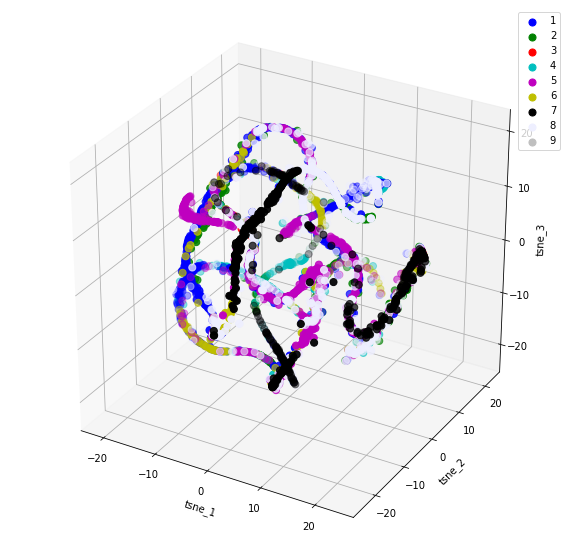

In [47]:
prepro_x(x_delta,'0')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3810 samples in 0.933s...
[t-SNE] Computed neighbors for 3810 samples in 59.513s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3810
[t-SNE] Computed conditional probabilities for sample 2000 / 3810
[t-SNE] Computed conditional probabilities for sample 3000 / 3810
[t-SNE] Computed conditional probabilities for sample 3810 / 3810
[t-SNE] Mean sigma: 0.675697
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.534340
[t-SNE] KL divergence after 1000 iterations: 0.473445
(3810, 3)


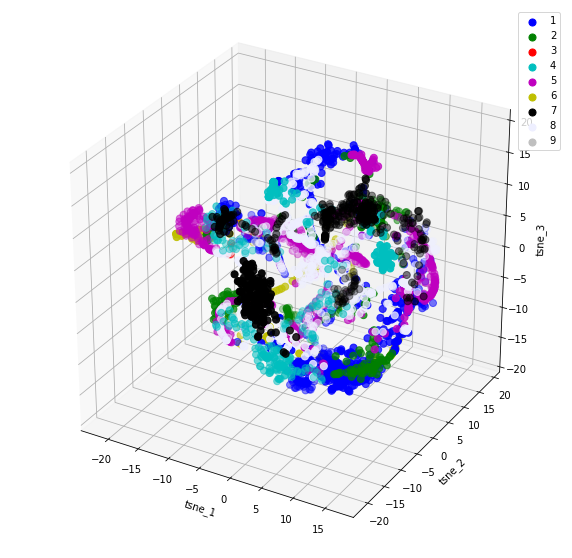

In [48]:
prepro_x(x_delta_1,'1')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3810 samples in 0.838s...
[t-SNE] Computed neighbors for 3810 samples in 79.661s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3810
[t-SNE] Computed conditional probabilities for sample 2000 / 3810
[t-SNE] Computed conditional probabilities for sample 3000 / 3810
[t-SNE] Computed conditional probabilities for sample 3810 / 3810
[t-SNE] Mean sigma: 2.755570
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.540749
[t-SNE] KL divergence after 1000 iterations: 0.909820
(3810, 3)


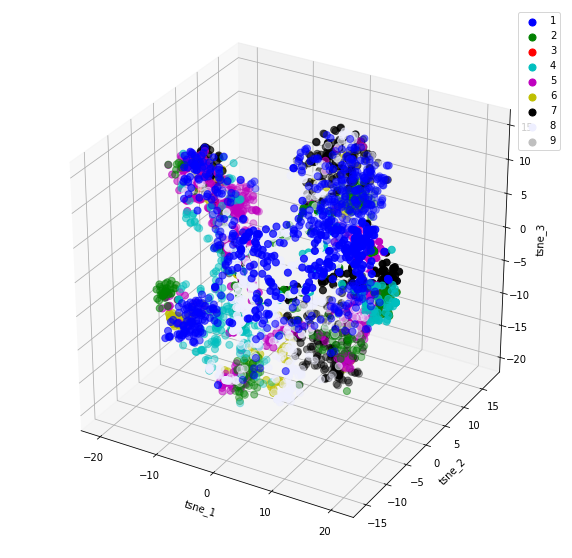

In [50]:
prepro_x(x_delta_2,'2')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3810 samples in 0.925s...
[t-SNE] Computed neighbors for 3810 samples in 90.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3810
[t-SNE] Computed conditional probabilities for sample 2000 / 3810
[t-SNE] Computed conditional probabilities for sample 3000 / 3810
[t-SNE] Computed conditional probabilities for sample 3810 / 3810
[t-SNE] Mean sigma: 1.099934
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.538452
[t-SNE] KL divergence after 1000 iterations: 0.631332
(3810, 3)


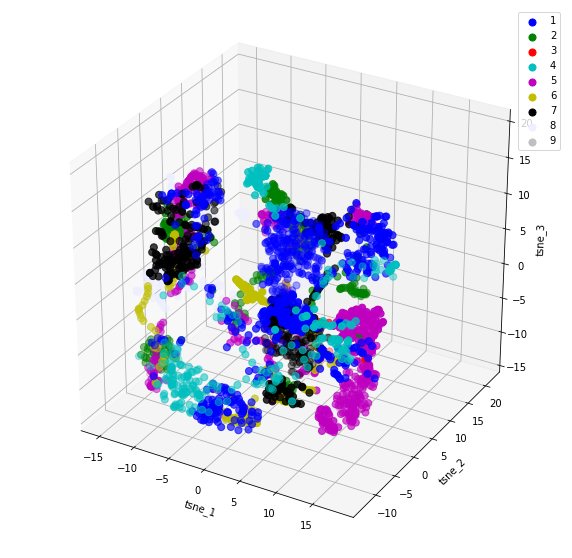

In [51]:
prepro_x(x_delta_3,'3')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3810 samples in 0.792s...
[t-SNE] Computed neighbors for 3810 samples in 85.500s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3810
[t-SNE] Computed conditional probabilities for sample 2000 / 3810
[t-SNE] Computed conditional probabilities for sample 3000 / 3810
[t-SNE] Computed conditional probabilities for sample 3810 / 3810
[t-SNE] Mean sigma: 2.251037
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.532780
[t-SNE] KL divergence after 1000 iterations: 0.862088
(3810, 3)


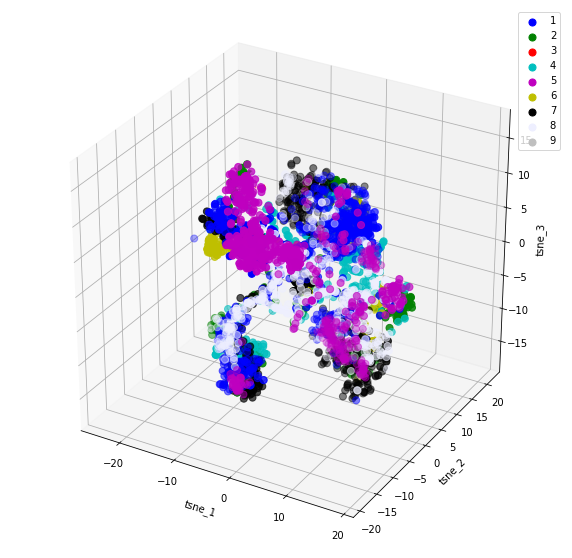

In [52]:
prepro_x(x_delta_4,'4')

In [74]:
x_data = np.concatenate((x_quaternion,x_delta_1),axis=-1)
y_data = y
print(x_data.shape,y_data.shape)

(3810, 128, 8) (3810, 9)


In [76]:
from keras.layers import *
from keras.models import Model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [77]:
def nn_model(dropout=0.4):
    inp = Input(shape=(128,8))
    x = SeparableConv1D(64,8,2,'same')(inp)
    x = PReLU()(x)
    x = Dropout(dropout)(x)
    
    x = SeparableConv1D(128,8,2,'same')(inp)
    x = PReLU()(x)
    x = Dropout(dropout)(x)
    
    x = SpatialDropout1D(0.1)(inp)
    x = CuDNNLSTM(units=128,return_sequences=True,return_state=True)(x)
    x = Dropout(dropout)(x)
    x = CuDNNLSTM(units=256,return_sequences=False)(x)
    x = Dropout(dropout)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = PReLU()(x)
    x = Dropout(dropout/2.)(x)
    
    x = Dense(128)(x)
    x = PReLU()(x)
    x = Dropout(dropout/2.)(x)
    y = Dense(9,activation='softmax')(x)
    model = Model(inputs=inp,outputs=y)
    model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model